# player detection

In [ ]:
from inference import get_model

ROBOFLOW_API_KEY = "KEY"
PLAYER_DETECTION_MODEL_ID = "tennis-match-cqbju/3"
# Creating an instance of the model, pulling the weights from the Roboflow universer and loading them into the memory
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

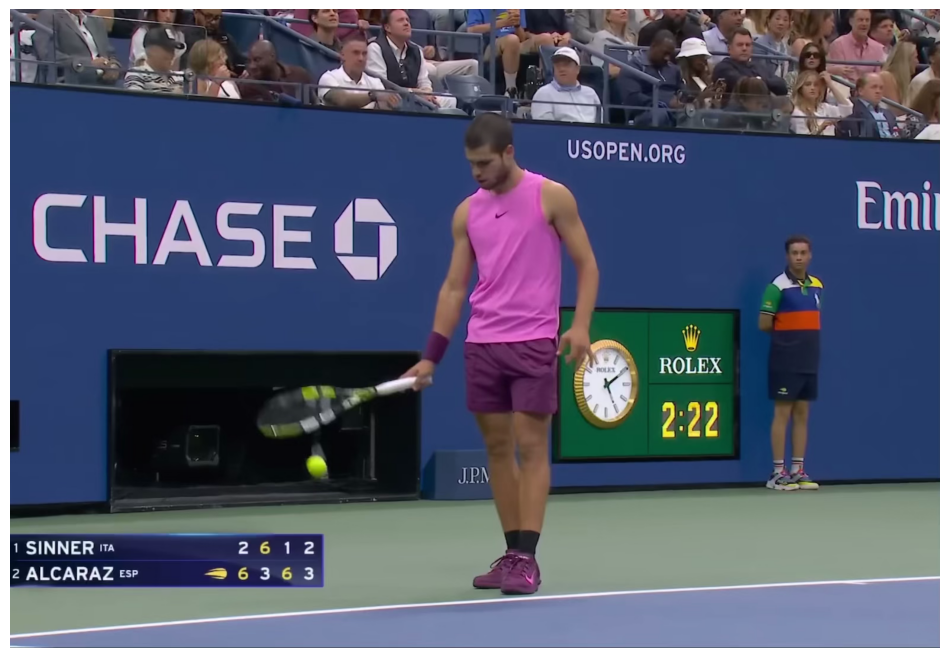

In [2]:
import supervision as sv

SOURCE_VIDEO_PATH = "val_vid.mov" # one of the demo video

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator) # get the first frame from the generator

sv.plot_image(frame)

In [4]:
from tqdm import tqdm
import supervision as sv

SOURCE_VIDEO_PATH = "val_vid.mov" 
TARGET_VIDEO_PATH = "val_vid_result.mov"

box_annotator = sv.BoxAnnotator( # initailize bounding boxes annotation
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF']),
    thickness=2
)
label_annotator = sv.LabelAnnotator( # initalize label annotation
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF']),
    text_color=sv.Color.from_hex('#000000') 
)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # run the model on the frame, specify confidence threshold, why [0] see play.py
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0] 
        detections = sv.Detections.from_inference(result) # wrap the result into supervision detections

        labels = [ # labels we want to show in the annotation
            f"{class_name} {confidence:.2f}"
            for class_name, confidence
            in zip(detections['class_name'], detections.confidence)
        ]

        annotated_frame = frame.copy()
        annotated_frame = box_annotator.annotate( # bounding boxes
            scene=annotated_frame,
            detections=detections)
        annotated_frame = label_annotator.annotate( # label annotation
            scene=annotated_frame,
            detections=detections,
            labels=labels)
        video_sink.write_frame(annotated_frame)

100%|██████████| 9537/9537 [30:42<00:00,  5.18it/s]


# keypoint detector model debug

In [ ]:
from inference import get_model

# get the trained key point detection model from the Roboflow Universe
ROBOFLOW_API_KEY = "KEY"
FIELD_DETECTION_MODEL_ID = "tennis-court-detection-onesd-ipydn/1"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

In [ ]:
# setting up an environment variable that will be consumed by the inference package
# telling it which execution provider ONNX should use (we would like to use Cuda)
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [ ]:
import supervision as sv
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/content/val_vid.mov"
TARGET_VIDEO_PATH = "/content/val_vid_key_pt_result.mov"

vertex_annotator = sv.VertexAnnotator( # it uses dots to visualize all the anchors of the skeleton
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info) # this allows us to save videos to the hard drive

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink: # open the video sink with the with statement
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0] # run the model on the frame
        key_points = sv.KeyPoints.from_inference(result) # wrap it into the KeyPoints object from supervision

        annotated_frame = frame.copy()
        annotated_frame = vertex_annotator.annotate(
            scene=annotated_frame,
            key_points=key_points)

        video_sink.write_frame(annotated_frame)

# Court visualization

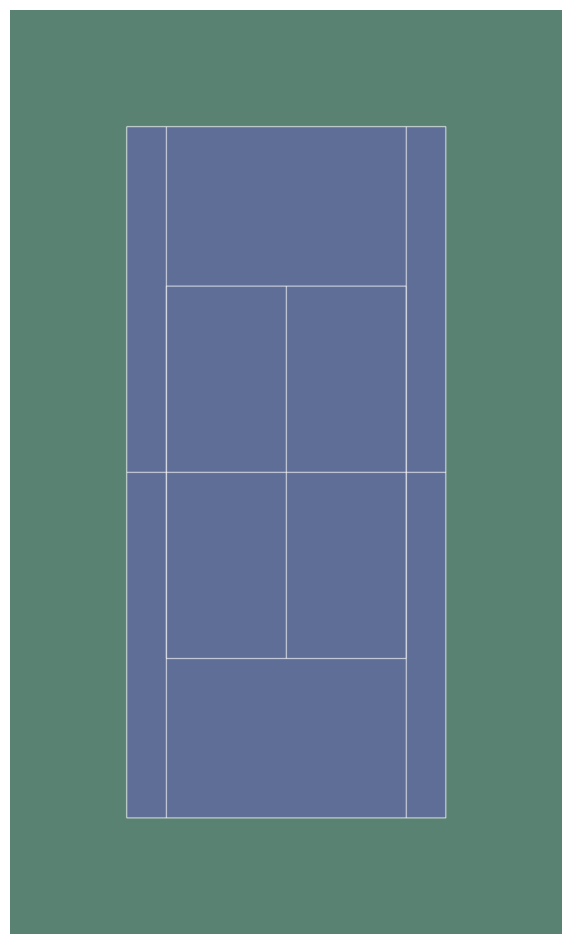

In [ ]:
import supervision as sv
from utils.annotators.tennis import draw_tennis_court
from utils.configs.tennis import TennisCourtConfiguration

# this class store information about coordinates of 14 points on a tennis court
CONFIG = TennisCourtConfiguration()

annotated_frame = draw_tennis_court(CONFIG)

sv.plot_image(annotated_frame)

# project court lines and vertices into a frame

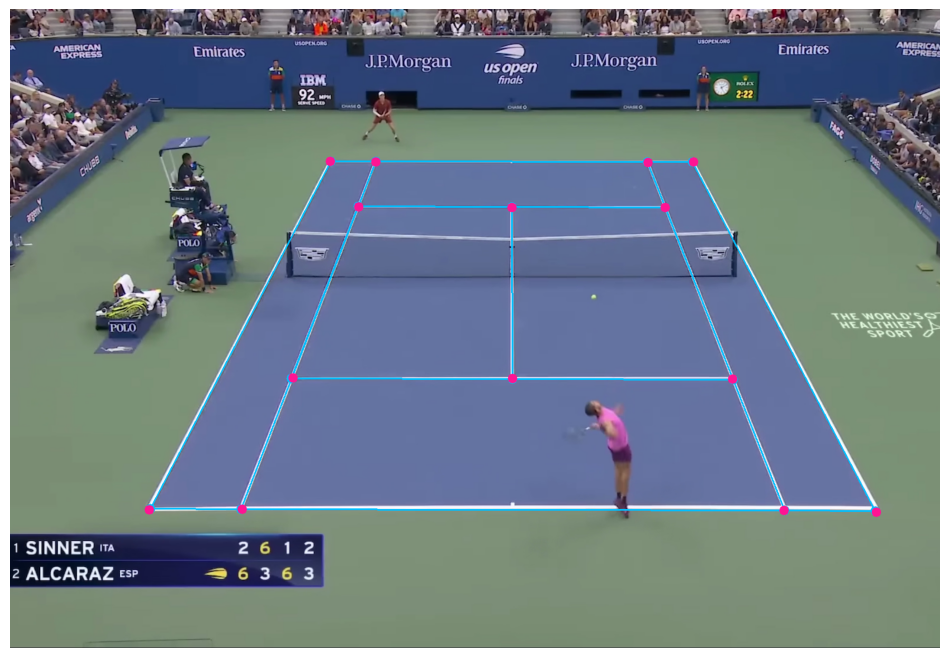

In [ ]:
import numpy as np
import supervision as sv
from utils.common.view import ViewTransformer
from utils.configs.tennis import TennisCourtConfiguration

SOURCE_VIDEO_PATH = "val_vid.mov" # one of the demo video

CONFIG = TennisCourtConfiguration()

edge_annotator = sv.EdgeAnnotator( # draw edges
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator( # draw vertex
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=400) # get frame 400
frame = next(frame_generator)
result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# recall key_points.confidence is (N, K), (N, 14)
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

# # we'll take all the points (and edges) we have and transform them from 
# bird eye perspective to camera perspective
court_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer( # from bird eye to camera
    source=court_reference_points,
    target=frame_reference_points
)

# get all points from bird eye, and transform them to camera perspective
# we get all points so we can draw points that don't even exist in the camera frame
# but more importantly we'll be able to draw the edges (lines) connecting the vertices
court_all_points = np.array(CONFIG.vertices)
# boom, transform
frame_all_points = transformer.transform_points(points=court_all_points)
# create new KeyPoints object
frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points) # edged found from transformation
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points) # transformed keypoints from bird eye key points
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points) # Key Points detected by YOLO algo

sv.plot_image(annotated_frame)

# transformation from camera view to bird eye

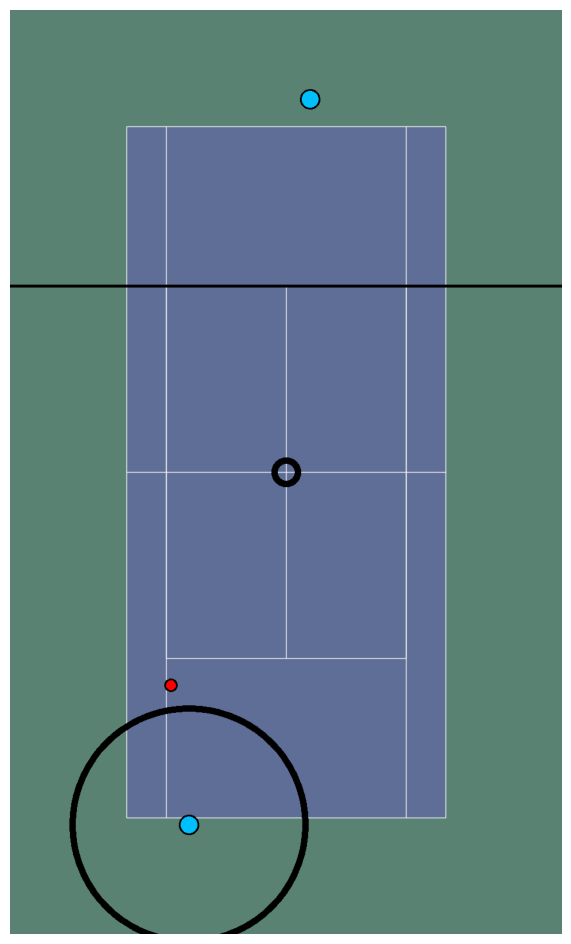

In [ ]:
import numpy as np
import supervision as sv
from utils.configs.tennis import TennisCourtConfiguration
from utils.common.view import ViewTransformer
import cv2
from utils.annotators.tennis import (
    draw_tennis_court,
    draw_points_on_court,
)

SOURCE_VIDEO_PATH = "val_vid.mov"
BALL_ID = 0
PLAYER_ID = 2

CONFIG = TennisCourtConfiguration()

tracker = sv.ByteTrack()
tracker.reset()

for i in range(1955, 1956):

    frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=i) # get frame 400
    frame = next(frame_generator)

    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    # ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10) # pad the ball boxes a bit, so it's easier to look at without overlapping on the ball itself

    player_detections = detections[detections.class_id == PLAYER_ID]
    # update_with_detections returns an updated Detections object. The key difference in the output is that the tracker_id field is populated. 
    # The tracker has assigned a consistent, unique ID to each detected object that it matched to an existing (or new) track
    # In essence, update_with_detections converts raw, per-frame object detections into persistent, labeled object tracks across the video sequence
    player_detections = tracker.update_with_detections(detections=player_detections)

    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

    # recall key_points.confidence is (N, K), (N, 14)
    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]

    court_reference_points = np.array(CONFIG.vertices)[filter]

    transformer = ViewTransformer( # from camera to bird eye
        source=frame_reference_points,
        target=court_reference_points
    )

    # convert boxes into points, a coordinate
    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    court_ball_xy = transformer.transform_points(points=frame_ball_xy)

    players_xy = player_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    court_players_xy = transformer.transform_points(points=players_xy)

    court = draw_tennis_court(config=CONFIG)
    court = draw_points_on_court(config=CONFIG, 
                                xy=court_ball_xy, 
                                court=court)
    court = draw_points_on_court(config=CONFIG, 
                                xy=court_players_xy, 
                                face_color=sv.Color.from_hex('00BFFF'),
                                edge_color=sv.Color.BLACK,
                                radius=16,
                                court=court)
    sinner_location = court_players_xy[1]
    sinner_location = (
                int(sinner_location[0] * 0.5) + 200,
                int(sinner_location[1] * 0.5) + 200
            )
    cv2.circle(
                img=court,
                center=sinner_location,
                radius=200,
                color=sv.Color.BLACK.as_bgr(),
                thickness=10 # draws only the circumference or edge of the circle
            )
    cv2.circle(
                img=court,
                center=(474, 794),
                radius=20,
                color=sv.Color.BLACK.as_bgr(),
                thickness=10 # draws only the circumference or edge of the circle
            )
    
    cv2.line(court, (0, 474), (court.shape[1], 474), color=sv.Color.BLACK.as_bgr(), thickness=4)


    sv.plot_image(court)

# let's generate some 2d videos

In [ ]:
import supervision as sv
from tqdm import tqdm
import numpy as np
from utils.annotators.tennis import (
    draw_tennis_court,
    draw_points_on_court,
)
from utils.common.view import ViewTransformer

SOURCE_VIDEO_PATH = "short_clip.mov"
TARGET_VIDEO_PATH = "short_clip_results.mp4"
BALL_ID = 0
PLAYER_ID = 2

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Build first court image to determine output resolution
court0 = draw_tennis_court(CONFIG)

# video out_info
out_info = sv.VideoInfo(
    width=court0.shape[1],
    height=court0.shape[0],
    fps=video_info.fps,
    total_frames=video_info.total_frames
)

H, W = court0.shape[:2]

video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=out_info) # this allows us to save videos to the hard drive

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        # ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10) # pad the ball boxes a bit, so it's easier to look at without overlapping on the ball itself

        player_detections = detections[detections.class_id == PLAYER_ID]
        # update_with_detections returns an updated Detections object. The key difference in the output is that the tracker_id field is populated. 
        # The tracker has assigned a consistent, unique ID to each detected object that it matched to an existing (or new) track
        # In essence, update_with_detections converts raw, per-frame object detections into persistent, labeled object tracks across the video sequence
        player_detections = tracker.update_with_detections(detections=player_detections)

        result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)

        # recall key_points.confidence is (N, K), (N, 14)
        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]

        court_reference_points = np.array(CONFIG.vertices)[filter]

        transformer = ViewTransformer( # from camera to bird eye
            source=frame_reference_points,
            target=court_reference_points
        )

        # convert boxes into points, a coordinate
        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        court_ball_xy = transformer.transform_points(points=frame_ball_xy)

        players_xy = player_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        court_players_xy = transformer.transform_points(points=players_xy)

        court = draw_tennis_court(config=CONFIG)
        court = draw_points_on_court(config=CONFIG, 
                                    xy=court_ball_xy, 
                                    court=court)
        court = draw_points_on_court(config=CONFIG, 
                                    xy=court_players_xy, 
                                    face_color=sv.Color.from_hex('00BFFF'),
                                    edge_color=sv.Color.BLACK,
                                    radius=16,
                                    court=court)
        
        assert court.ndim == 3 and court.shape[2] == 3
        assert court.shape[0] == H and court.shape[1] == W

        # court = np.ascontiguousarray(court, dtype=np.uint8)  # good habit for VideoWriter
        video_sink.write_frame(court)

# Epsilon ball

False


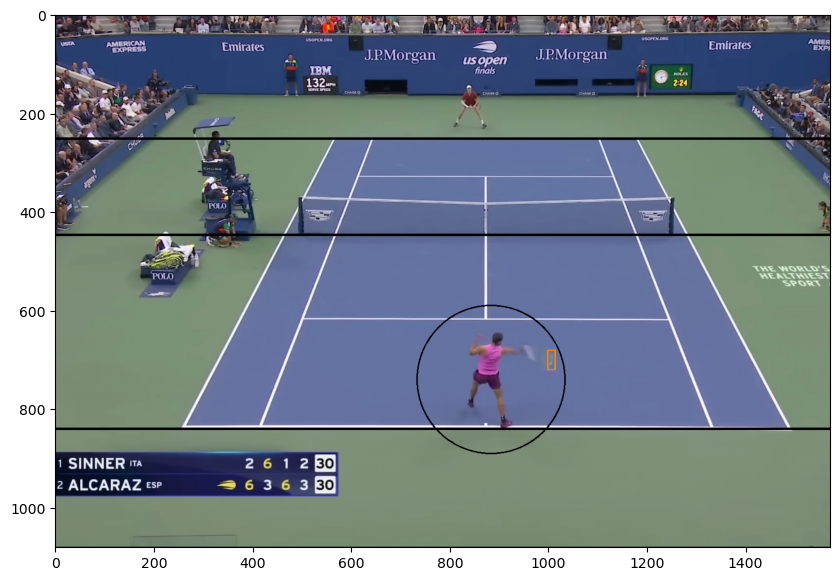

In [ ]:
import matplotlib.pyplot as plt

BALL_ID = 0
PLAYER_ID = 2

NEAR_BASELINE_LEFT_DOUBLE_CORNER_IDX = 1-1 # recall the keypoints are 1-based
NEAR_BASELINE_RIGHT_DOUBLE_CORNER_IDX = 4-1 
FAR_BASELINE_RIGHT_DOUBLE_CORNER_IDX = 5-1
FAR_BASELINE_LEFT_DOUBLE_CORNER_IDX = 8-1


CONFIG = TennisCourtConfiguration()

SOURCE_VIDEO_PATH = "short_clip.mov"

box_annotator = sv.BoxAnnotator( # initailize bounding boxes annotation
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF']),
    thickness=2
)
label_annotator = sv.LabelAnnotator( # initalize label annotation
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF']),
    text_color=sv.Color.from_hex('#000000') 
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=345)
frame = next(frame_generator)
# frame = Image.open("dist_frame.png").convert("RGB")
# frame = np.array(frame)
 # run the model on the frame, specify confidence threshold, why [0] see play.py
result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0] 
detections = sv.Detections.from_inference(result) # wrap the result into supervision detections

ball_detections = detections[detections.class_id == BALL_ID]
player_detections = detections[detections.class_id == PLAYER_ID]

players_xy = player_detections.get_anchors_coordinates(sv.Position.CENTER)
# player_foot_xy = player_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
ball_xy = ball_detections.get_anchors_coordinates(sv.Position.CENTER)[0] # TODO ball might not exist

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)
key_points_xy = key_points.xy[0] # (14, 2)

# recall key_points.confidence is (N, K), (N, 14)
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]

court_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer( # from bird eye to camera
    source=court_reference_points,
    target=frame_reference_points
)

center_x_bird_eye = (CONFIG.singles_x0 + CONFIG.singles_x1) / 2 
center_y_bird_eye = CONFIG.net_y
center_of_the_court_bird_eye = np.array([[center_x_bird_eye, center_y_bird_eye]])
center_of_the_court = transformer.transform_points(points=center_of_the_court_bird_eye)[0]

top_player_loc = players_xy[0] if players_xy[0][1] < center_of_the_court[1] else players_xy[1]
bot_player_loc = players_xy[0] if players_xy[0][1] > center_of_the_court[1] else players_xy[1]

dist_btw_ball_n_top = float(np.linalg.norm(ball_xy - top_player_loc))
print(dist_btw_ball_n_top < 100)

near_baseline_y = (key_points_xy[NEAR_BASELINE_LEFT_DOUBLE_CORNER_IDX][1]
                   + key_points_xy[NEAR_BASELINE_RIGHT_DOUBLE_CORNER_IDX][1]) / 2
far_baseline_y = (key_points_xy[FAR_BASELINE_LEFT_DOUBLE_CORNER_IDX][1]
                   + key_points_xy[FAR_BASELINE_RIGHT_DOUBLE_CORNER_IDX][1]) / 2

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate( # bounding boxes
    scene=annotated_frame,
    detections=ball_detections)

sinner_location = (int(top_player_loc[0]), int(top_player_loc[1]))
alcaraz_location = (int(bot_player_loc[0]), int(bot_player_loc[1]))

cv2.circle(
            img=annotated_frame,
            center=alcaraz_location,
            radius=150,
            color=sv.Color.BLACK.as_bgr(),
            thickness=2 # draws only the circumference or edge of the circle
            )
cv2.line(annotated_frame, (0, int(far_baseline_y)), (annotated_frame.shape[1], int(far_baseline_y)), color=sv.Color.BLACK.as_bgr(), thickness=4)
cv2.line(annotated_frame, (0, int(near_baseline_y)), (annotated_frame.shape[1], int(near_baseline_y)), color=sv.Color.BLACK.as_bgr(), thickness=4)
cv2.line(annotated_frame, (0, int(center_of_the_court[1])), (annotated_frame.shape[1], int(center_of_the_court[1])), color=sv.Color.BLACK.as_bgr(), thickness=4)

annotated_frame = annotated_frame[:, :, ::-1]
plt.figure(figsize=(10, 10))
plt.imshow(annotated_frame)

# Player img patch extractor

True


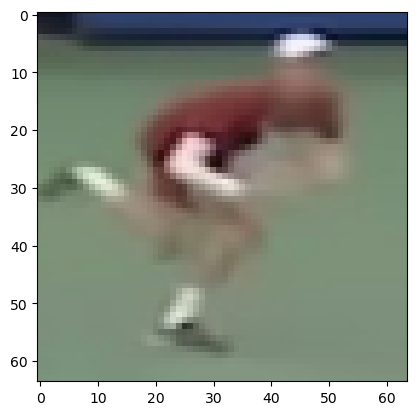

In [ ]:
BALL_ID = 0
PLAYER_ID = 2

NEAR_BASELINE_LEFT_DOUBLE_CORNER_IDX = 1-1 # recall the keypoints are 1-based
NEAR_BASELINE_RIGHT_DOUBLE_CORNER_IDX = 4-1 
FAR_BASELINE_RIGHT_DOUBLE_CORNER_IDX = 5-1
FAR_BASELINE_LEFT_DOUBLE_CORNER_IDX = 8-1


CONFIG = TennisCourtConfiguration()

SOURCE_VIDEO_PATH = "short_clip.mov"

box_annotator = sv.BoxAnnotator( # initailize bounding boxes annotation
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF']),
    thickness=2
)
label_annotator = sv.LabelAnnotator( # initalize label annotation
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF']),
    text_color=sv.Color.from_hex('#000000') 
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=275)
frame = next(frame_generator)

 # run the model on the frame, specify confidence threshold, why [0] see play.py
result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0] 
detections = sv.Detections.from_inference(result) # wrap the result into supervision detections

ball_detections = detections[detections.class_id == BALL_ID]
player_detections = detections[detections.class_id == PLAYER_ID]

hitting_player = np.linalg.norm(ball_xy - players_xy, axis=1) < 100 # boolean array (2,)
player_detection_of_interest = player_detections[hitting_player]
print(np.sum(hitting_player) > 0)

crops = sv.crop_image(frame, player_detection_of_interest.xyxy)
crops = cv2.resize(crops, (64, 64))
crops = crops[:, :, ::-1]
plt.imshow(crops)

# next, we'll identify during the point / out of the point frames

In [ ]:
import numpy as np
def check_during_pt(detections, key_points):

    BALL_ID = 0
    PLAYER_ID = 2

    during_pt_frame = True 
    ball_detections = detections[detections.class_id == BALL_ID]
    player_detections = detections[detections.class_id == PLAYER_ID]

    if ball_detections.xyxy.shape[0] != 1:
        # no ball or more than 1 ball detected
        during_pt_frame = False

    if player_detections.xyxy.shape[0] != 2:
        # there is no enough player detected or 
        # more than two players on court (in case of detecting ball boy)
        during_pt_frame = False

    if (key_points.xy.shape[0] == 0) or (np.sum(key_points.confidence[0] > 0.5) < 10):
        # no tennis court detected
        # or not enough confident key points were detected 
        during_pt_frame = False

    return during_pt_frame

In [ ]:
import supervision as sv
from tqdm import tqdm
import cv2

SOURCE_VIDEO_PATH = "val_vid.mov" 
TARGET_VIDEO_PATH = "val_vid_result.mov"

box_annotator = sv.BoxAnnotator( # initailize bounding boxes annotation
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF']),
    thickness=2
)
label_annotator = sv.LabelAnnotator( # initalize label annotation
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF']),
    text_color=sv.Color.from_hex('#000000') 
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

during_pt = False
out_of_pt_frame_counter = 0 

with video_sink:
    for frame_number, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames)):

        # run the model on the frame, specify confidence threshold, why [0] see play.py
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.6)[0] 
        detections = sv.Detections.from_inference(result)

        result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)

        if check_during_pt(detections, key_points):
            during_pt = True
            out_of_pt_frame_counter = 0
        else:
            out_of_pt_frame_counter += 1
        
        if out_of_pt_frame_counter > video_info.fps*2:
            # consistently out of point for around 2 seconds.
            during_pt = False

        labels = [ # labels we want to show in the annotation
            f"{class_name} {confidence:.2f}"
            for class_name, confidence
            in zip(detections['class_name'], detections.confidence)
        ]

        annotated_frame = frame.copy()
        annotated_frame = box_annotator.annotate( # bounding boxes
            scene=annotated_frame,
            detections=detections)
        annotated_frame = label_annotator.annotate( # label annotation
            scene=annotated_frame,
            detections=detections,
            labels=labels)
        

        cv2.putText(
            annotated_frame,                               
            f"During point: {during_pt}",         
            (10, 30),                             
            cv2.FONT_HERSHEY_SIMPLEX,              
            1.0,                                   
            (255, 255, 255),                      
            2,                                     
            cv2.LINE_AA)
        
        video_sink.write_frame(annotated_frame)
